In [25]:
import sys
import os
os.chdir('/home/samhuang/ML/sample')
add_path = '/home/samhuang/ML/sample'
if add_path not in sys.path:
    sys.path.insert(0,add_path)
print(sys.path)
from tfr_utils import *
import ROOT as r
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm
from matplotlib import colors
import tensorflow as tf

mpl.rcParams['figure.facecolor'] = 'white'

r.gROOT.ProcessLine('.include /usr/local/Delphes-3.4.2/')
r.gROOT.ProcessLine('.include /usr/local/Delphes-3.4.2/external/')
r.gInterpreter.Declare('#include "/usr/local/Delphes-3.4.2/classes/DelphesClasses.h"')
r.gInterpreter.Declare('#include "/usr/local/Delphes-3.4.2/external/ExRootAnalysis/ExRootTreeReader.h"')
r.gInterpreter.Declare('#include "/usr/local/Delphes-3.4.2/external/ExRootAnalysis/ExRootConfReader.h"')
r.gInterpreter.Declare('#include "/usr/local/Delphes-3.4.2/external/ExRootAnalysis/ExRootTask.h"')
r.gSystem.Load("/usr/local/Delphes-3.4.2/build/libDelphes")
r.gSystem.Load("/usr/local/lib/libDelphes")

['/home/samhuang/ML/sample', '/home/samhuang', '/usr/local/root-6.20.08/installdir/lib', '/home/samhuang/.conda/envs/sam/lib/python38.zip', '/home/samhuang/.conda/envs/sam/lib/python3.8', '/home/samhuang/.conda/envs/sam/lib/python3.8/lib-dynload', '', '/home/samhuang/.conda/envs/sam/lib/python3.8/site-packages']


1

In [26]:
directory= str(add_path+"/test3/Events/run_7/tag_1_delphes_events.root") # small test data
directory1= str(add_path+"/VBF_H5pp_ww_jjjj/Events/run_1/tag_1_delphes_events.root")
directory2= str(add_path+"/VBF_H5mm_ww_jjjj/Events/run_01/tag_1_delphes_events.root")
directory3= str(add_path+"/VBF_H5z_zz_jjjj/Events/run_01/tag_1_delphes_events.root")
f = r.TFile.Open(add_path+'/test3/Events/run_7/tag_1_delphes_events.root', "READ")
tree = f.Get ("Delphes")
File = r.TChain("Delphes;1")
File.Add(directory)
File.Add(directory1)
File.Add(directory2)
File.Add(directory3)
N = File.GetEntries()
print ("Number of events:", N)
num=0
for b in File.GetListOfBranches():
    if num %2==0:
        print ("branch :", b.GetName(), end='\n')
    num+=1

Number of events: 4000000
branch : Event
branch : Weight
branch : Particle
branch : Track
branch : Tower
branch : EFlowTrack
branch : EFlowPhoton
branch : EFlowNeutralHadron
branch : GenJet
branch : GenMissingET
branch : Jet
branch : Electron
branch : Photon
branch : Muon
branch : FatJet
branch : MissingET
branch : ScalarHT


# Functions

In [27]:
def std_phi(phi):
	if phi > np.pi:
		return phi - 2.*np.pi
	elif phi < -np.pi:
		return phi + 2.*np.pi
	else:
		return phi

def std_Deltaphi(Deltaphi):
	if Deltaphi > np.pi:
		return 2.*np.pi - Deltaphi
	elif Deltaphi < -np.pi:
		return 2.*np.pi + Deltaphi
	else:
		return Deltaphi

In [29]:
def preprocess(jet, constituents, kappa):
	pt_sum, eta_central, phi_central = 0., 0., 0.
	s_etaeta, s_etaphi, s_phiphi = 0., 0., 0.
	pt_quadrants = [0., 0., 0., 0.]
	eta_flip, phi_flip = 1., 1.
	pt_news, eta_news, phi_news, Q_kappas = [], [], [], []

	for consti_id, consti in enumerate(constituents):
		try:
			pt_sum += consti.PT
			eta_central += consti.PT * consti.Eta
			phi_central += consti.PT * std_phi(consti.Phi)
			Q_kappas.append((consti.Charge)*(consti.PT)**kappa/(jet.PT)**kappa)
			pt_news.append(consti.PT)
		except:
			pt_sum += consti.ET
			eta_central += consti.ET * consti.Eta
			phi_central += consti.ET * std_phi(consti.Phi)
			Q_kappas.append(0.)
			pt_news.append(consti.ET)
	
	eta_central /= pt_sum
	phi_central /= pt_sum

	for consti_id, consti in enumerate(constituents):
		try:
			s_etaeta += consti.PT * (consti.Eta - eta_central)**2
			s_phiphi += consti.PT * (std_phi(consti.Phi) - phi_central)**2
			s_etaphi += consti.PT * (consti.Eta - eta_central) * (std_phi(consti.Phi) - phi_central)
		except:
			s_etaeta += consti.ET * (consti.Eta - eta_central)**2
			s_phiphi += consti.ET * (std_phi(consti.Phi) - phi_central)**2
			s_etaphi += consti.ET * (consti.Eta - eta_central) * (std_phi(consti.Phi) - phi_central)
	
	s_etaeta /= pt_sum
	s_etaphi /= pt_sum
	s_phiphi /= pt_sum

	angle = -np.arctan((-s_etaeta + s_phiphi + np.sqrt((s_etaeta - s_phiphi)**2 + 4. * s_etaphi**2))/(2. * s_etaphi))

	for consti_id, consti in enumerate(constituents):
		eta_shift, phi_shift = consti.Eta - eta_central, std_phi(consti.Phi - phi_central)
		eta_rotat, phi_rotat = eta_shift * np.cos(angle) - phi_shift * np.sin(angle), phi_shift * np.cos(angle) + eta_shift * np.sin(angle)

		eta_news.append(eta_rotat)
		phi_news.append(phi_rotat)

		try:
			if eta_rotat > 0. and phi_rotat > 0.:
				pt_quadrants[0] += consti.PT
			elif eta_rotat > 0. and phi_rotat < 0.:
				pt_quadrants[1] += consti.PT
			elif eta_rotat < 0. and phi_rotat < 0.:
				pt_quadrants[2] += consti.PT
			elif eta_rotat < 0. and phi_rotat > 0.:
				pt_quadrants[3] += consti.PT

		except:
			if eta_rotat > 0. and phi_rotat > 0.:
				pt_quadrants[0] += consti.ET
			elif eta_rotat > 0. and phi_rotat < 0.:
				pt_quadrants[1] += consti.ET
			elif eta_rotat < 0. and phi_rotat < 0.:
				pt_quadrants[2] += consti.ET
			elif eta_rotat < 0. and phi_rotat > 0.:
				pt_quadrants[3] += consti.ET

	if np.argmax(pt_quadrants) == 1:
		phi_flip = -1.
	elif np.argmax(pt_quadrants) == 2:
		phi_flip = -1.
		eta_flip = -1.
	elif np.argmax(pt_quadrants) == 3:
		eta_flip = -1.

	eta_news = [eta_new * eta_flip for eta_new in eta_news]
	phi_news = [phi_new * phi_flip for phi_new in phi_news]

	return pt_news, eta_news, phi_news, Q_kappas

In [30]:
def list_float_feature(features):
        """ Create feature for list of floats"""
        return _list_float_feature(features)

def list_of_lists_float_feature(features):
        """ Creates a FeatureList object from a list of lists of floats"""
        return _list_of_lists_float_feature(features)
        
def get_sequence_example_object(data_element_dict):
        """ Creates a SequenceExample object from a dictionary for a single data element
        data_element_dict is a dictionary for each element in .json file created by the fastjet code.
        """
        # Context contains all scalar and list features
        context = tf.train.Features(
                        feature=
                        {
                                'labels' : list_float_feature(data_element_dict['labels']),
                                'pTj' : list_float_feature(data_element_dict['pTj']),
                                'Qkj' : list_float_feature(data_element_dict['Qkj']),
                        }
        )

        # Feature_lists contains all lists of lists
        feature_lists = tf.train.FeatureLists(
                        feature_list=
                       {
                                'pT'   : list_of_lists_float_feature(data_element_dict['pT']),
                                'Qk'   : list_of_lists_float_feature(data_element_dict['Qk']),
                       }
        )

        sequence_example = tf.train.SequenceExample(context = context, feature_lists = feature_lists)

        return sequence_example

## List of the Branch

In [34]:
for b in tree.GetBranch("Event").GetListOfBranches():
    print (b.GetName(), end='\t')
print ("\n===========================================================================================================")
for b in tree.GetBranch("Particle").GetListOfBranches():
    print (b.GetName(), end='\t')
print ("\n===========================================================================================================")
for b in tree.GetBranch("Jet").GetListOfBranches():
    print (b.GetName(), end='\t')

Event.fUniqueID	Event.fBits	Event.Number	Event.ReadTime	Event.ProcTime	Event.ProcessID	Event.MPI	Event.Weight	Event.CrossSection	Event.CrossSectionError	Event.Scale	Event.AlphaQED	Event.AlphaQCD	Event.ID1	Event.ID2	Event.X1	Event.X2	Event.ScalePDF	Event.PDF1	Event.PDF2	
Particle.fUniqueID	Particle.fBits	Particle.PID	Particle.Status	Particle.IsPU	Particle.M1	Particle.M2	Particle.D1	Particle.D2	Particle.Charge	Particle.Mass	Particle.E	Particle.Px	Particle.Py	Particle.Pz	Particle.P	Particle.PT	Particle.Eta	Particle.Phi	Particle.Rapidity	Particle.CtgTheta	Particle.D0	Particle.DZ	Particle.T	Particle.X	Particle.Y	Particle.Z	
Jet.fUniqueID	Jet.fBits	Jet.PT	Jet.Eta	Jet.Phi	Jet.T	Jet.Mass	Jet.DeltaEta	Jet.DeltaPhi	Jet.Flavor	Jet.FlavorAlgo	Jet.FlavorPhys	Jet.BTag	Jet.BTagAlgo	Jet.BTagPhys	Jet.TauTag	Jet.TauWeight	Jet.Charge	Jet.EhadOverEem	Jet.NCharged	Jet.NNeutrals	Jet.Beta	Jet.BetaStar	Jet.MeanSqDeltaR	Jet.PTD	Jet.FracPt[5]	Jet.Tau[5]	Jet.SoftDroppedJet	Jet.SoftDroppedSubJet1	Jet.SoftDroppedS

In [18]:
def sample_selection(pbar, tfwriter, imagewriter,values, json_list, Npass, evt_total):
	data_collect = []
	for evt_id, evt in enumerate(File):
		pTj, Qkj = [], []
		if (evt_id > total):
			break
		particle_number = 2 #// number of the particle in the final state
		particle_list = []
		tmp_particle_list = []
		for particle_id, particle in enumerate(evt.Particle):
			if (abs(particle.PID) in [255,257]) and (abs(evt.Particle[particle.D1].PID) in [23,24]) and (abs(evt.Particle[particle.D2].PID) in [23,24]):
				#print ('=====================================================')
				#print ("Event", evt_id, "PID", particle.PID, particle.Eta, particle.Phi, "PT", particle.PT)
				#print (evt.Particle[particle.D1].PT, evt.Particle[particle.D2].PT)
				#print (evt.Particle[particle.D1].Eta, evt.Particle[particle.D2].Eta)
				#print (evt.Particle[particle.D1].Phi, evt.Particle[particle.D2].Phi)
				#print (particle.D1, particle.D2)
				#print (evt.Particle[particle.D1].PID, evt.Particle[particle.D2].PID)
				#print (evt.Particle[evt.Particle[particle.D1].D1].PID, evt.Particle[evt.Particle[particle.D1].D2].PID, evt.Particle[evt.Particle[particle.D2].D1].PID, evt.Particle[evt.Particle[particle.D2].D2].PID)
				if (particle.D1< particle.D2) and (abs(evt.Particle[particle.D1].PID) in [23, 24]) and (abs(evt.Particle[particle.D2].PID) in [23, 24]) and (abs(evt.Particle[evt.Particle[particle.D1].D1].PID) <= 6) and (abs(evt.Particle[evt.Particle[particle.D1].D2].PID) <= 6) and (abs(evt.Particle[evt.Particle[particle.D2].D1].PID) <= 6) and (abs(evt.Particle[evt.Particle[particle.D2].D2].PID) <= 6):
					p1, p2 = evt.Particle[evt.Particle[particle.D1].D1], evt.Particle[evt.Particle[particle.D1].D2]
					p3, p4 = evt.Particle[evt.Particle[particle.D2].D1], evt.Particle[evt.Particle[particle.D2].D2]
					#print ("pass1")
					Npass[0] += 1
					if (p1.Eta - p2.Eta)**2 + std_Deltaphi(std_phi(p1.Phi) - std_phi(p2.Phi))**2 < 0.6**2 and (p3.Eta - p4.Eta)**2 + std_Deltaphi(std_phi(p3.Phi) - std_phi(p4.Phi))**2 < 0.6**2:
						particle_list = [evt.Particle[particle.D1],evt.Particle[particle.D2]]
						#print ("pass2")
						Npass[1] += 1
						break

		if len(particle_list) != 2:
			pbar.update(1)
			continue
		#print (evt_id, p1.Status, p1.M1, p1.M2,  p2.Status, p2.M1, p2.M2)
		Npass[2] += 1

		jet_list = []
		particle_order_list = []
		for jet_id, jet in enumerate(evt.Jet):
			eta_jet, phi_jet = jet.Eta, std_phi(jet.Phi)
			#print (evt_id, jet_id, evt.Jet.GetEntries(), eta_jet, jet.PT)
			if (abs(jet.PT-400.) >= 50. or abs(eta_jet) > 1.):
				continue
			#print ("pass3")
			Npass[3] += 1
			particle_order_list.append([])
			[p1, p2] = particle_list
			#print ((eta_jet - p1.Eta)**2 + std_Deltaphi((phi_jet - std_phi(p1.Phi)))**2, (eta_jet - p2.Eta)**2 + std_Deltaphi((phi_jet - std_phi(p2.Phi)))**2  )
			if (eta_jet - p1.Eta)**2 + std_Deltaphi((phi_jet - std_phi(p1.Phi)))**2 < 0.1**2: #// \Delta R (V_1,j) < 0.1
				particle_order_list[-1].append(1)
			if (eta_jet - p2.Eta)**2 + std_Deltaphi((phi_jet - std_phi(p2.Phi)))**2 < 0.1**2: #// \Delta R (V_2,j) < 0.1
				particle_order_list[-1].append(2)
			if (len(particle_order_list[-1])>0):
				jet_list.append(jet)

		particle_order_list.append([]) #//make sure the shape of the list is the same
				
		#print ("N of jet:", len(jet_list))
		#print (particle_order_list, np.sum(particle_order_list), len(np.unique(np.sum(particle_order_list))), len(jet_list) < 2 or (len(np.unique(np.sum(particle_order_list)))!=2))
		if len(jet_list) < 2 or (len(np.unique(np.sum(particle_order_list)))!=2):
				pbar.update(1)
				continue
		Npass[4] += 1
		#print (evt_id, "found")
		#print (particle_list[0].Eta, particle_list[1].Eta)
		#print (std_phi(particle_list[0].Phi), std_phi(particle_list[1].Phi))
		#print (jet_list[0].Eta, jet_list[1].Eta)
		#print (std_phi(jet_list[0].Phi), std_phi(jet_list[1].Phi))

		json_obj = {'particle_type': [], 'nodes': [], 'pT': None, 'Qk': None, 'pTj': [], 'Qkj': []}

		kappa = 0.15
		
		jet = jet_list[0]
		constituents = [consti for consti in jet.Constituents if consti != 0]
		pt_news, eta_news, phi_news, Q_kappas = preprocess(jet, constituents, kappa)
		
		for id_1st, consti in enumerate(constituents):
			Rin = np.sqrt((consti.Eta - jet.Eta)**2 + std_Deltaphi(std_phi(consti.Phi) - std_phi(jet.Phi))**2)
			json_obj['nodes'].append([pt_news[id_1st], consti.Eta, std_phi(consti.Phi), eta_news[id_1st], phi_news[id_1st],
			pt_news[id_1st]/jet.PT, Rin, Q_kappas[id_1st]])
 

		eta_list = [x[3] for x in json_obj['nodes']]
		phi_list = [x[4] for x in json_obj['nodes']]
		pT_list  = [x[0] for x in json_obj['nodes']]
		Qk_list  = [x[7] for x in json_obj['nodes']]
		pTj.append(pT_list)
		Qkj.append(Qk_list)
		jet1_mass = jet.Mass
		jet1_Qk   = sum(Q_kappas)
		
		

		#print ("################################")
		#print (eta_list)
		#print (phi_list)
		#print (pT_list)

		

		hpT1, _, _ = np.histogram2d(eta_list, phi_list, range=((-0.8, 0.8), (-0.8, 0.8)), bins=(75, 75), weights=pT_list)
		hQk1, _, _ = np.histogram2d(eta_list, phi_list, range=((-0.8, 0.8), (-0.8, 0.8)), bins=(75, 75), weights=Qk_list)

		jet = jet_list[1]
		constituents = [consti for consti in jet.Constituents if consti != 0]
		pt_news, eta_news, phi_news, Q_kappas = preprocess(jet, constituents, kappa)
		
		for id_1st, consti in enumerate(constituents):
			Rin = np.sqrt((consti.Eta - jet.Eta)**2 + std_Deltaphi(std_phi(consti.Phi) - std_phi(jet.Phi))**2)
			json_obj['nodes'].append([pt_news[id_1st], consti.Eta, std_phi(consti.Phi), eta_news[id_1st], phi_news[id_1st],
			pt_news[id_1st]/jet.PT, Rin, Q_kappas[id_1st]])
 

		eta_list = [x[3] for x in json_obj['nodes']]
		phi_list = [x[4] for x in json_obj['nodes']]
		pT_list  = [x[0] for x in json_obj['nodes']]
		Qk_list  = [x[7] for x in json_obj['nodes']]
		pTj.append(pT_list)
		Qkj.append(Qk_list)
		jet2_mass = jet.Mass
		jet2_Qk   = sum(Q_kappas)
		json_obj['pTj'] = [item for sublist in pTj for item in sublist]
		json_obj['Qkj'] = [item for sublist in pTj for item in sublist]
		
		if particle_list[0].PID!=particle_list[1].PID:
			print (particle_list[0].PID, particle_list[1].PID)
			print ("particle type of two particles are not the same")
		elif particle_list[0].PID==24:
			json_obj['particle_type']='W+'
			json_obj['labels']=[1,0,0]#'W+'
		elif particle_list[0].PID==-24:
			json_obj['particle_type']='W-'
			json_obj['labels']=[0,1,0]#'W-'
		elif abs(particle_list[0].PID)==23:
			json_obj['particle_type']='Z'
			json_obj['labels']=[0,0,1]#'Z'
		else:
			print (particle_list[0].PID)
			print ("no particle type")
   

		data_collect.append([json_obj['particle_type'], jet1_mass, jet1_Qk])
		data_collect.append([json_obj['particle_type'], jet2_mass, jet2_Qk])

		#print ("################################")
		#print (eta_list)
		#print (phi_list)
		#print (pT_list)

		hpT2, _, _ = np.histogram2d(eta_list, phi_list, range=((-0.8, 0.8), (-0.8, 0.8)), bins=(75, 75), weights=pT_list)
		hQk2, _, _ = np.histogram2d(eta_list, phi_list, range=((-0.8, 0.8), (-0.8, 0.8)), bins=(75, 75), weights=Qk_list)

		#print ("################################")
		#print (len((hpT1+hpT2)[(hpT1+hpT2)==0]))

		json_obj['pT'] = (hpT1+hpT2)#.tolist()
		json_obj['Qk'] = (hQk1+hQk2)#.tolist()
		json_list.append(json_obj)
  
		#sequence_example = get_sequence_example_object(json_obj)
		#print (sequence_example)
		#tfwriter.write(sequence_example.SerializeToString())

		#image = np.array([np.array(json_obj['particle_type']), json_obj['pT'], json_obj['Qk']], dtype=object)
		image = np.array([np.array(json_obj['particle_type']), hpT1+hpT2, hQk1+hQk2], dtype=object)
		np.save(imagewriter, image)

		evt_total += 1
		pbar.update(1)
		
	return evt_total, data_collect

			



In [21]:
outputfilename = 'samples_kappa0.15/samples_kappa0.15'
outname = outputfilename+'.tfrecord'
imagename = outputfilename+'.npy'
countname = outputfilename+'.count'
values = []
json_list=[]
Npass = np.zeros(5)
total = File.GetEntries()
evt_total = 0 
with tqdm(total) as pbar:
    with tf.io.TFRecordWriter(outname) as tfwriter:
        with open(imagename, 'wb') as imagewriter:
            evt_total, data_collection = sample_selection(pbar, tfwriter, imagewriter,values, json_list, Npass, evt_total)

with open(countname, 'w+') as ffff:
    ffff.write('{0:d}\n'.format(evt_total))
print (Npass, "out of", total)



4000000it [4:18:06, 258.29it/s]


[2724620. 2254055. 2254055. 2820665.  636414.] out of 4000000


In [22]:
df = pd.DataFrame([])
data_collection = np.array(data_collection)
df['particle_type'] = data_collection[:,0]
df['jet mass'] = (data_collection[:,1]).astype(float)
df['jet charge'] = data_collection[:,2].astype(float)
df.to_csv(outputfilename+'_properties.txt')
print ((df))
print (len(df))

        particle_type    jet mass  jet charge
0                   Z   91.308884    0.663452
1                   Z   94.920250    0.937650
2                  W-   95.522499   -0.029069
3                  W-  117.614731    1.024724
4                  W+   77.652779   -0.352659
...               ...         ...         ...
1272823             Z   88.031036    0.858011
1272824             Z  104.798340    0.328097
1272825             Z  106.449562   -0.601815
1272826             Z   92.293846    2.781909
1272827             Z   77.807259   -0.050157

[1272828 rows x 3 columns]
1272828


# Jet Sample

Total data amount: 636414
(75, 75)
Z
(5587,)


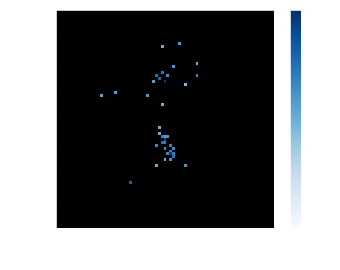

In [23]:
%matplotlib inline
Npoint=3
print ("Total data amount:", len(json_list))
print (np.shape(json_list[Npoint]['pT']))
a = np.asarray(json_list[Npoint]['pT'])
print (json_list[Npoint]['particle_type'])
print (np.shape(a[a==0]))
plt.imshow(json_list[Npoint]['pT'], extent=[-0.8, 0.8, -0.8, 0.8], cmap='Blues', interpolation='nearest', norm=colors.LogNorm(vmin=0.01))
plt.colorbar()
plt.xlabel(r'$\phi^\prime$')
plt.ylabel(r'$\eta^\prime$')
plt.show()

In [24]:
%matplotlib inline
N_Wp=0; N_Wm=0; N_Z=0
pT_Wp=0; pT_Wm=0; pT_Z=0
Qk_Wp=0; Qk_Wm=0; Qk_Z=0
for js_id, js in enumerate(json_list):
    if (js['particle_type']=='W+'):
        N_Wp += 1
        pT_Wp += np.array(js['pT'])
        Qk_Wp += np.array(js['Qk'])
    elif (js['particle_type']=='W-'):
        N_Wm += 1
        pT_Wm += np.array(js['pT'])
        Qk_Wm += np.array(js['Qk'])
    elif (js['particle_type']=='Z'):
        N_Z += 1
        pT_Z += np.array(js['pT'])
        Qk_Z += np.array(js['Qk'])
    else:
        print('No.%d does not have a particle_type' %js_id)

print (N_Z, N_Wp, N_Wm)
print (len(df))

271607 195622 169185
1272828


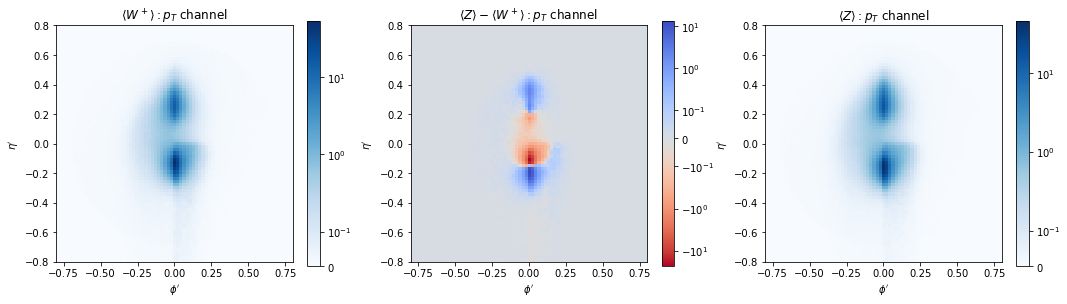

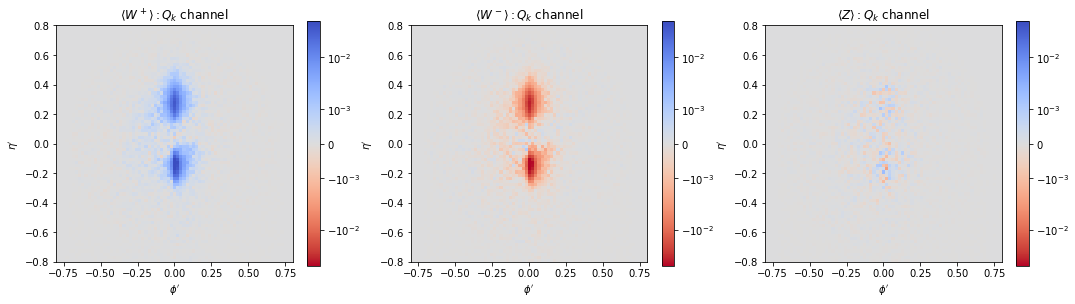

In [14]:
fig, ax = plt.subplots(1,3, figsize=(18,5))
## P_T distribution
imag = ax[0].imshow(pT_Wp/N_Wp, extent=[-0.8, 0.8, -0.8, 0.8], norm=colors.SymLogNorm(linthresh=0.1, linscale=0.4,vmin=0), cmap='Blues')
plt.colorbar(imag, ax=ax[0], shrink=0.9)
ax[0].set_title(r'$\langle W^+\rangle: p_T$ channel')
ax[0].set_xlabel(r'$\phi^\prime$')
ax[0].set_ylabel(r'$\eta^\prime$')

imag = ax[1].imshow(pT_Z/N_Z - pT_Wp/N_Wp, extent=[-0.8, 0.8, -0.8, 0.8], norm=colors.SymLogNorm(linthresh=0.1, linscale=0.6), cmap='coolwarm_r')
plt.colorbar(imag, ax=ax[1], shrink=0.9)
ax[1].set_title(r'$\langle Z \rangle-\langle W^+\rangle: p_T$ channel')
ax[1].set_xlabel(r'$\phi^\prime$')
ax[1].set_ylabel(r'$\eta^\prime$')

imag = ax[2].imshow(pT_Z/N_Z, extent=[-0.8, 0.8, -0.8, 0.8], norm=colors.SymLogNorm(linthresh=0.1, linscale=0.4,vmin=0), cmap='Blues')
plt.colorbar(imag, ax=ax[2], shrink=0.9)
ax[2].set_title(r'$\langle Z \rangle: p_T$ channel')
ax[2].set_xlabel(r'$\phi^\prime$')
ax[2].set_ylabel(r'$\eta^\prime$')
plt.show()
plt.close()

## Q_k distribution
fig, ax = plt.subplots(1,3, figsize=(18,5))
imag = ax[0].imshow(Qk_Wp/N_Wp, extent=[-0.8, 0.8, -0.8, 0.8], interpolation='nearest', norm=colors.SymLogNorm(linthresh=0.001, linscale=0.6,vmax=5e-2,vmin=-5e-2), cmap='coolwarm_r')
plt.colorbar(imag, ax=ax[0], shrink=0.9)
ax[0].set_title(r'$\langle W^+\rangle: Q_k$ channel')
ax[0].set_xlabel(r'$\phi^\prime$')
ax[0].set_ylabel(r'$\eta^\prime$')

imag = ax[1].imshow(Qk_Wm/N_Wm, extent=[-0.8, 0.8, -0.8, 0.8], interpolation='nearest', norm=colors.SymLogNorm(linthresh=0.001, linscale=0.6,vmax=5e-2,vmin=-5e-2), cmap='coolwarm_r')
plt.colorbar(imag, ax=ax[1], shrink=0.9)
ax[1].set_title(r'$\langle W^-\rangle: Q_k$ channel')
ax[1].set_xlabel(r'$\phi^\prime$')
ax[1].set_ylabel(r'$\eta^\prime$')

imag = ax[2].imshow(Qk_Z/N_Z, extent=[-0.8, 0.8, -0.8, 0.8], interpolation='nearest', norm=colors.SymLogNorm(linthresh=0.001, linscale=0.6,vmax=5e-2,vmin=-5e-2), cmap='coolwarm_r')
plt.colorbar(imag, ax=ax[2], shrink=0.9)
ax[2].set_title(r'$\langle Z \rangle: Q_k$ channel')
ax[2].set_xlabel(r'$\phi^\prime$')
ax[2].set_ylabel(r'$\eta^\prime$')
plt.show()

In [15]:
a1 = df[df['particle_type']=='W+']
a2 = df[df['particle_type']=='W-']
a3 = df[df['particle_type']=='Z']
a1_figure, yedges, xedges = np.histogram2d(a1['jet mass'].values, a1['jet charge'].values, range=[[60, 120], [-2, 2]], bins=(75, 75))
a2_figure, yedges, xedges = np.histogram2d(a2['jet mass'].values, a2['jet charge'].values, range=((60, 120), (-2, 2)), bins=(75, 75))
a3_figure, yedges, xedges = np.histogram2d(a3['jet mass'].values, a3['jet charge'].values, range=((60, 120), (-2, 2)), bins=(75, 75))

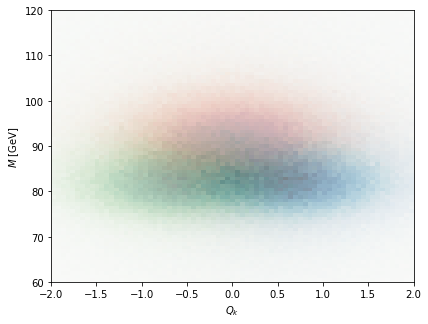

In [16]:
%matplotlib inline
fig, ax = plt.subplots(1,1, figsize=(15,5))
myextent  = [xedges[0],xedges[-1],yedges[0],yedges[-1]]
ax.imshow(a1_figure, extent=myextent, cmap='Blues', alpha=1,aspect='equal', interpolation='nearest', origin='lower')
ax.imshow(a2_figure, extent=myextent, cmap='Greens', alpha=0.4,aspect='equal', interpolation='nearest', origin='lower')
ax.imshow(a3_figure, extent=myextent, cmap='Reds', alpha=0.25,aspect='equal', interpolation='nearest', origin='lower')
#ax.set_xlim([-2,2])
#ax.set_ylim([60,120])
ax.set_xlabel(r'$Q_k$')
ax.set_ylabel(r'$M$ [GeV]')
ax.set_aspect(0.05)
plt.show()

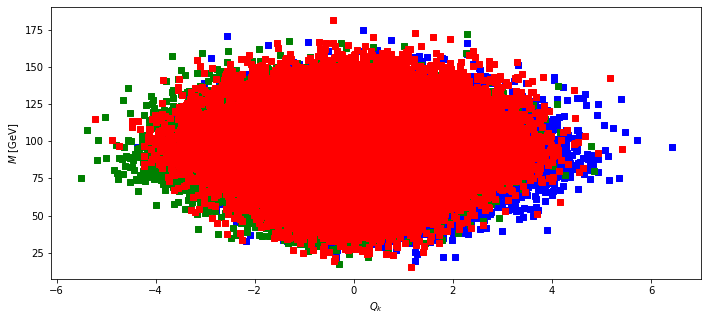

In [17]:
%matplotlib inline
fig, ax = plt.subplots(1,1, figsize=(15,5))
ax.scatter(a1['jet charge'], a1['jet mass'], c='b', marker='s')
ax.scatter(a2['jet charge'], a2['jet mass'], c='g', marker='s')
ax.scatter(a3['jet charge'], a3['jet mass'], c='r', marker='s')

#ax.set_xlim([-2,2])
#ax.set_ylim([60,120])
ax.set_xlabel(r'$Q_k$')
ax.set_ylabel(r'$M$ [GeV]')
ax.set_aspect(0.03)
plt.show()

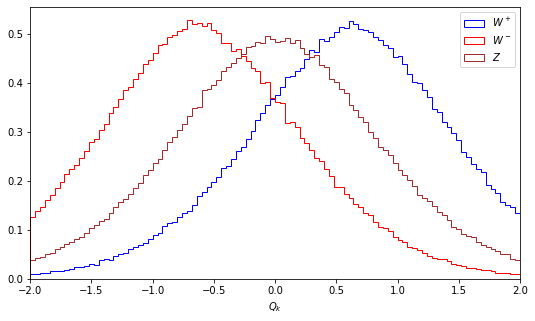

In [18]:
%matplotlib inline
fig, ax = plt.subplots(1,1, figsize=(15,5))
ax.hist(a1['jet charge'], color='b', histtype='step', density=True, bins=100, range=[-2,2], label=r'$W^+$')
ax.hist(a2['jet charge'], color='r', histtype='step', density=True, bins=100, range=[-2,2], label=r'$W^-$')
ax.hist(a3['jet charge'], color='brown', histtype='step', density=True, bins=100, range=[-2,2], label=r'$Z$')

ax.legend()
ax.set_xlim([-2,2])
#ax.set_ylim([60,120])
ax.set_xlabel(r'$Q_k$')
ax.set_aspect(4)
plt.show()

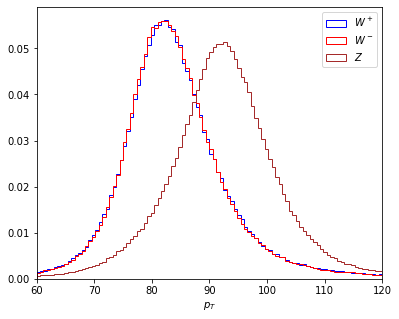

In [19]:
%matplotlib inline
fig, ax = plt.subplots(1,1, figsize=(15,5))
ax.hist(a1['jet mass'], color='b', histtype='step', density=True, bins=100, range=[60,120], label=r'$W^+$')
ax.hist(a2['jet mass'], color='r', histtype='step', density=True, bins=100, range=[60,120], label=r'$W^-$')
ax.hist(a3['jet mass'], color='brown', histtype='step', density=True, bins=100, range=[60,120], label=r'$Z$')

ax.legend()
ax.set_xlim([60,120])
#ax.set_ylim([60,120])
ax.set_xlabel(r'$p_T$')
ax.set_aspect(800)
plt.show()

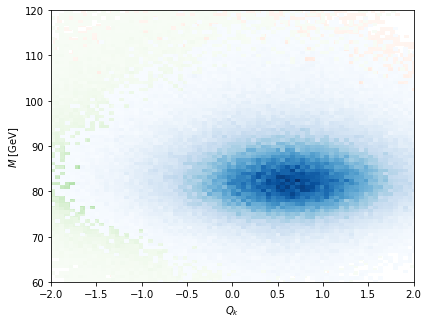

In [ ]:
%matplotlib inline
fig, ax = plt.subplots(1,1, figsize=(15,5))
ax.hist2d(a3['jet charge'], a3['jet mass'], bins=200, cmin=5, cmap='Reds', alpha=1)
ax.hist2d(a2['jet charge'], a2['jet mass'], bins=200, cmin=2, cmap='Greens', alpha=1)
imag = ax.hist2d(a1['jet charge'], a1['jet mass'], bins=200, cmin=5, cmap='Blues', alpha=1)

ax.set_xlim([-2,2])
ax.set_ylim([60,120])
ax.set_xlabel(r'$Q_k$')
ax.set_ylabel(r'$M$ [GeV]')
ax.set_aspect(0.05)
plt.show()